In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import sys
import os
sys.path.append('../')
from fastai.vision import *
from modules.basics import *
from PIL import Image, ImageDraw, ImageFont
from concurrent.futures import ProcessPoolExecutor

In [3]:
IMG_PATH, DATA_PATH

(PosixPath('/home/giles/Documents/kaggle/higgsml'), PosixPath('../data'))

In [4]:
IMG_PATH = DATA_PATH/'higgsml'

In [9]:
!python ../modules/data_import.py -d {DATA_PATH} -c False #-f PRI_jet_num -r True -z True -y True -h

Training on 200000 datapoints and validating on 50000, using 30 feats:
['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met_pt', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']
Running train
rm: cannot remove ‘../data/train.hdf5’: No such file or directory
Saving fold: 0 of 20001 events
Saving fold: 1 of 20001 events
Saving fold: 2 of 20001 events
Saving fold: 3 of 20001 events
Saving fold: 4 of 20000 events
Saving fold: 5 of 20000 events
Saving fold: 6 of 19999 events
Saving fold: 7 of 19999 events
Saving fold: 8 of 19

In [10]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    feats = pickle.load(fin)
cont_feats = feats['cont_feats']
cat_feats = feats['cat_feats']    
cat_maps = feats['cat_maps']  
cat_szs = feats['cat_szs']  
train_feats = cont_feats + cat_feats

In [11]:
train_fy = FoldYielder(h5py.File(DATA_PATH/'train.hdf5', "r+"), cont_feats, cat_feats)
train_fy.add_input_pipe_from_file(DATA_PATH/'input_pipe.pkl')

In [12]:
df = train_fy.get_df(inc_inputs=True, deprocess=True); len(df); df.head()

200000 candidates loaded


/home/giles/anaconda3/envs/fastai/lib/python3.6/site-packages/lumin/nn/data/fold_yielder.py:115: UserWarning: pred not found in foldfile file
  warnings.warn(f'{pred_name} not found in foldfile file')


,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,gen_target,gen_weight
0,120.280998,40.030998,87.237000,72.169998,0.000,0.000000,0.00,2.001,2.070999,175.783005,...,1.000000e+00,73.836998,0.346,2.888,0.000000,0.000,0.000,7.383700e+01,1,0.000048
1,105.942001,44.081001,65.517998,30.698999,0.000,0.000000,0.00,2.736,30.698999,58.908005,...,-1.611710e-08,0.000000,0.000,0.000,0.000000,0.000,0.000,9.804058e-07,0,0.000153
2,137.251999,3.769001,80.249001,138.690994,7.055,1841.645996,-12.39,1.606,29.180000,222.315002,...,2.000000e+00,69.866997,-3.758,2.923,41.963001,3.297,-3.038,1.118300e+02,1,0.000027
3,153.136993,40.298000,102.665001,19.563000,0.000,0.000000,0.00,3.117,19.563000,101.463997,...,-1.611710e-08,0.000000,0.000,0.000,0.000000,0.000,0.000,9.804058e-07,1,0.000335
4,122.495003,33.615002,97.281998,268.632996,0.432,228.552994,4.27,1.199,53.695999,615.632019,...,2.000000e+00,339.315002,1.861,-2.051,37.374001,2.294,0.299,3.766890e+02,1,0.000027


In [13]:
font = ImageFont.truetype('FreeMonoBold.ttf', 13)

In [14]:
def event2img(event:np.ndarray, size:int=224) -> PIL.Image.Image:
    img = Image.fromarray(np.zeros([size,size,3]), 'RGB')
    for i, f in enumerate(event):
        ImageDraw.Draw(img).text(((0.25+(i%2))*size//2,(i//2)*2*size//len(event)), f'{f:.3f}', fill=(255,255,255), font=font)
    return img

In [16]:
len(train_feats)

30

CPU times: user 72 ms, sys: 20.9 ms, total: 92.9 ms
Wall time: 92 ms


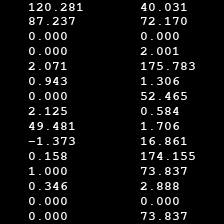

In [15]:
%%time
event2img(df[train_feats].values[0])

In [17]:
train_fy = FoldYielder(h5py.File(DATA_PATH/'train.hdf5', "r+"), cont_feats, cat_feats)
train_fy.add_input_pipe_from_file(DATA_PATH/'input_pipe.pkl')
train_df = train_fy.get_df(inc_inputs=True, deprocess=True)

200000 candidates loaded


/home/giles/anaconda3/envs/fastai/lib/python3.6/site-packages/lumin/nn/data/fold_yielder.py:115: UserWarning: pred not found in foldfile file
  warnings.warn(f'{pred_name} not found in foldfile file')


In [18]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"), cont_feats, cat_feats)
val_fy.add_input_pipe_from_file(DATA_PATH/'input_pipe.pkl')
val_df = val_fy.get_df(inc_inputs=True, deprocess=True)

50000 candidates loaded


In [19]:
train_df = train_df.append(val_df, ignore_index=True)

In [23]:
len(train_df)

250000

In [24]:
for mode in ['train', 'test']: os.makedirs(IMG_PATH/'images'/mode, exist_ok=True)

In [21]:
def save_image(event:np.ndarray, name:Union[str, int, float], loc:Path, size:int=224) -> None:
    img = event2img(event, size)
    name = str(name)
    if '.' not in name: name += '.png'
    img.save(loc/name)

In [22]:
def proc_sample(df:pd.DataFrame, mode:str, size:int=224) -> None:
    func = partial(save_image, loc=IMG_PATH/'images'/mode, size=size)
    with ProcessPoolExecutor(10) as e: e.map(func, df[train_feats].values, df.index.values)

In [25]:
%%time
proc_sample(train_df, 'train')

CPU times: user 1min 49s, sys: 16.6 s, total: 2min 6s
Wall time: 5min 50s


In [26]:
train_df.reset_index(inplace=True)
train_df.rename(columns={'index':'image_name'}, inplace=True)
train_df.to_csv(IMG_PATH/'train.csv', index=False)

In [27]:
%%time
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"), cont_feats, cat_feats)
test_fy.add_input_pipe_from_file(DATA_PATH/'input_pipe.pkl')
test_df = test_fy.get_df(inc_inputs=True, deprocess=True)
test_df['private'] = test_fy.get_column('private')
proc_sample(test_df, 'test')

/home/giles/anaconda3/envs/fastai/lib/python3.6/site-packages/lumin/nn/data/fold_yielder.py:115: UserWarning: pred not found in foldfile file
  warnings.warn(f'{pred_name} not found in foldfile file')


550000 candidates loaded
CPU times: user 3min 58s, sys: 36.8 s, total: 4min 35s
Wall time: 13min 4s


In [28]:
test_df.reset_index(inplace=True)
test_df.rename(columns={'index':'image_name'}, inplace=True)
test_df.to_csv(IMG_PATH/'test.csv', index=False)